# Phase Detection with Neural Networks: Interpreting the Black Box

The aim of this Jupyter Notebook is to give a step-by-step introduction to the use of influence functions in the CNNs trained for phase classification problems. It accompanies the paper 'Phase Detection with Neural Networks: Interpreting the Black Box' by A. Dawid, P. Huembeli, M. Tomza, M. Lewenstein, and A. Dauphin (collaboration of ICFO, Spain and University of Warsaw, Poland) available at [arXiv](https://arxiv.org/abs/2004.04711). Its aim is to reproduce the Fig. 2 from the article.

The scope of the notebook is the following:

1. Production of dataset, namely ground states of the transition line between liquid Luttinger (LL) phase and charge-density wave-I (CDW-I) phase in the 1D system of spinless fermions at half filling, exhibiting nearest-neighbor interactions $V_1$ and hopping between sites with amplitude $J$.

2. Training of a small CNN to recognize both phases.

3. Calculation of influence functions for chosen test points and the whole training data set.

4. Produce Fig. 2

The notebook was written in such a way that every out of 4 parts can be run separately -> every section has necessary libraries and variables, even if previous section already imported or defined them.

## 1. Production of data set

The ground states are calculated for the 12-site system with exact diagonalization method implemented in [QuSpin](https://scipost.org/SciPostPhys.2.1.003).

In [1]:
%load_ext autoreload
%autoreload 2
from quspin.operators import hamiltonian # Hamiltonian
from quspin.basis import spinless_fermion_basis_1d # Hilbert space fermion basis

import numpy as np # general math functions
import scipy # for diagonalization methods
import matplotlib.pyplot as plt # plotting
from time import time # tool for calculating computation time
from tqdm.notebook import trange # for the progress bar
from utility_general import save_to_file, append_to_file # to save the data sets
from utility_general import check_uniqueness # to compare training, validation and test points

### Package versions

`matplotlib.__version__ = 3.1.3`

`torch.__version__ = 1.4.0`

`quspin.__version__ = 3.1.3`

### Define the Hamiltonian

In [4]:
def calc_GS_energy(J, V1, V2, L, N, h1, h2, dJ, method='full'):
    basis_f = spinless_fermion_basis_1d(L, Nf=N) # fermion basis
    
    hh = [1,0,-1, 0]
    
    hop_f_right = [[-J/2 - dJ*(-1)**i ,i,(i+1)%L] for i in range(L)] # f hopping right
    hop_f_left =  [[-J/2 - dJ*(-1)**i ,i,(i+1)%L] for i in range(L)] # f hopping left
    int_list_ff = [[V1,i,(i+1)%L] for i in range(L)] # ff nearest-neighbour interactiona
    int_list_ff2 = [[V2,i,(i+2)%L] for i in range(L)] # ff next nearest-neighbour interaction
    field1 = [[(-1)**(i)*h1, i] for i in range(L)]
    field2 = [[hh[i%4]*h2, i] for i in range(L)]

    ## For some reason the hopping terms have minus signs at some places where they actually should not have one
    ## Therefore we use Quspin to construct the hopping Hamiltonian and then we take the absolute value and add a global minus sign
    static = [
    ["+-", hop_f_left], # fermions hop left
    ["-+", hop_f_right]    
    ]
    
    dynamic = [] # Dynamic part of H is just 0

    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,dynamic,basis=basis_f,**no_checks)
    
    H = -np.abs(H.toarray())
    H = np.array(H, dtype='complex128')
    H = np.real(H)
    #print(H)

    ## Sanity check: is it hermitian?
    #print(np.allclose(hmatrix, hmatrix.H, rtol=1e-05, atol=1e-08))
    
    ### Rest of Hamiltonian
    static = [
    ["zz", int_list_ff], # ff nn interaction z = (n-1/2)
    ["zz", int_list_ff2], # ff2 2nd nn interaction z = (n-1/2)
    # ["n", on_site],
    ["n", field1],
    ["n", field2]      
    ]
    
    ###### set up Hamiltonian and initial states
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    Hrest = hamiltonian(static,dynamic,basis=basis_f,**no_checks)
    H += np.real(Hrest.toarray())

    ## Sanity check: is it still hermitian?
    #print(np.allclose(hmatrix, hmatrix.H, rtol=1e-05, atol=1e-08))         

    if method=='Lanczos':
        H = scipy.sparse.csr_matrix(H)
        E,V = scipy.sparse.linalg.eigsh(H, k=1)
    elif method=='full':
        E,V = scipy.linalg.eigh(H)
    elif method=='Sparse':
        H = scipy.sparse.csr_matrix(H)
        E,V = scipy.sparse.linalg.eigsh(H, k=1)
    else:
        print("method must be either 'full' or 'Lanczos'!")
    return E, V

### Instructions

$J = 1.0$ is set throughout the whole code.

`h1` is the symmetry breaking field. For $V_1 = 1$ you have a phase transition from LL to CDW-I. 
But if you don't turn on any field, you won't see the CDW-I paterns well due to the degenerate ground state being in equal superposition of the two CDW states [10101010] and [01010101].
To see it, set h1 to a small value (e.g. 1e-7). Then set the transition point to the order parameter value 10x bigger than the appropriate symmetry breaking field.


### Define Order parameters for CDW

In [5]:
def calc_density(GS, L, Nf):
    basis_f=spinless_fermion_basis_1d(L,Nf=Nf)
    vec_density = []
    for i in range(L):
        n_1_static=[["n",[[1.0, i]]]]
        n_1=hamiltonian(n_1_static,[],basis=basis_f,dtype=np.float64,
                        check_herm=False,check_pcon=False, check_symm=False)
        a = n_1.dot(GS)
        vec_density.append(np.conj(GS).dot(a))
    return vec_density

In [6]:
def CDW_order_parameter(V,L,N, neighbour = 1): # define here if 1st or 2nd nearest neighbour 
    order_parameter = 0
    dens = calc_density(V, L, N)
    for i in range(L):
        order_parameter += abs(dens[i]-dens[(i+neighbour)%L])
    return order_parameter/L, dens

### Define values of $V_1$ for which you want to compute the order parameters

Remember to make sure that training points $\neq$ validation points $\neq$ test points. You preferably want the same number of points from both phases.

In [7]:
# Points from phase 0
train0 = np.linspace(0, 1, 500)
test0 = np.linspace(0.01, 0.999, 20)
validation0 = np.linspace(0.02, 0.998, 100)

# Points from phase 1
train1 = np.linspace(1.01, 40, 500)
test01 = np.linspace(1.02, 2, 5)
test1 = np.linspace(2.066, 39, 20)
validation1 = np.linspace(1.03, 39.998, 100)

check_uniqueness((train0, test0, validation0))
check_uniqueness((train1, test01, test1, validation1))

All is well!
All is well!


### Plot the order parameter

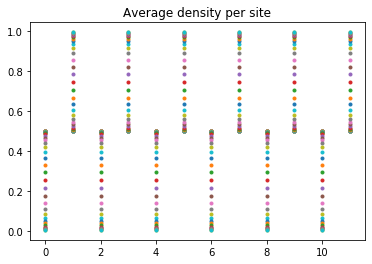

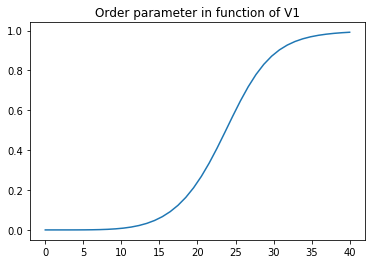

In [8]:
# Path for the produced data set
folder = 'datasets'
filename = 'ED_size12_fig2_test.csv'

J = 1.0 # hopping
L = 12 # system size
N = L//2 # half-filling

h1 = 1e-7 #imposing ABABAB pattern

order = []

# List of V_1 values from the transition line (1), from LL to CDW-I
V1_list = np.linspace(0, 40, 40) #np.concatenate((test0, test01, test1))

for i in trange (len(V1_list), desc='Calculating order param for different V1'):

    V1 = V1_list[i]
    #print("{} / {}".format(iterator, len(V1_list)))
    E, vec = calc_GS_energy(J, V1, 0, L, N, h1, 0, 0, method='full')
    eigenvector = vec[:,0]
    
    # Fixing the gauge - sign of the wavefunction is an irrelevant information
    if eigenvector[0] < 0:
        eigenvector = eigenvector*(-1)

    op, dens = CDW_order_parameter(eigenvector, L, N, neighbour=1)

    order.append(op)
    plt.plot(abs(np.array(dens)), '.')
    plt.title("Average density per site")

plt.show()
#save_to_file(order, 'order_' + filename + '.txt', './datasets')

plt.plot(V1_list, order)
plt.title("Order parameter in function of V1")
plt.show()

## 2. Training of a small CNN to recognize the phases

Architecture includes GAP, and has only 740 parameters, what enables exact calculating of the Hessian needed for influence functions. If your model is bigger, you can use stochastic approximation of the Hessian.

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import trange # for the progress bar

from matplotlib import pyplot as plt

from architectures import CNN1D_tiny_ED
from data_loader import Downloader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Define Network Parameters**

In [10]:
model_folder = 'model'
model_name = 'CNN_LLvsCDWI_l005'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Hyper-parameters 
input_size = 924    # state size
num_classes = 2    # LL or CDW
λ = 0.05 # Regularization
learning_rate = 0.1
num_epochs = 100

training_set_size = 1000
test_set_size = 45
batch_size = training_set_size

cpu


**Train**

Data loaded.


Epoch:  0 / 100 Accuracy:  50.0
Epoch:  10 / 100 Accuracy:  50.0
Epoch:  20 / 100 Accuracy:  50.0
Epoch:  30 / 100 Accuracy:  50.0
Epoch:  40 / 100 Accuracy:  99.5
Epoch:  50 / 100 Accuracy:  50.0
Epoch:  60 / 100 Accuracy:  83.0
Epoch:  70 / 100 Accuracy:  81.5
Epoch:  80 / 100 Accuracy:  96.5
Epoch:  90 / 100 Accuracy:  99.0



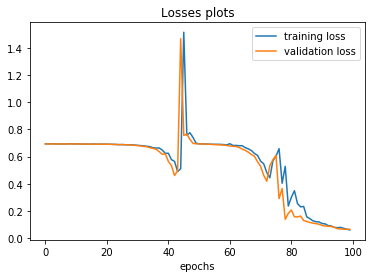

In [11]:
# Loading CDW data
CDW_data = Downloader('CDW_ED_size12_full', batch_size)
train_loader = CDW_data.train_loader() # it also produces the mask that allows to reverse the shuffling of training data - needed for influence functions
validation_loader = CDW_data.validation_loader(batch_size=200)

print("Data loaded.")

torch.manual_seed(17)

model = CNN1D_tiny_ED(num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=1.0)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,65], gamma=0.05)

# Train the model
hold_loss=[]
hold_val_loss = []

for epoch in trange(num_epochs, desc='Training'):
    
    for phase in ['train', 'val']:

        if phase == 'train':
            model.train()  # Set model to training mode

            for i, (eigenvectors, labels) in enumerate(train_loader):
                # Reshape eigenvectors to (batch_size, # of RGB channels, size, size)
                eigenvectors = eigenvectors.reshape(-1, 1, 924)

                eigenvectors, labels = eigenvectors.to(device), labels.to(device)

                # Forward pass
                outputs = model(eigenvectors)
                loss = criterion(outputs, labels)
                # We manually add L2 regularization
                if λ != 0:
                    l2_reg = 0.0
                    for param in model.parameters():
                        l2_reg += torch.norm(param)**2
                    loss += 1/training_set_size * λ/2 * l2_reg

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            hold_loss.append(loss.item())
            #print("Epoch: ", epoch, "Loss: ", loss.item())

        if phase == 'val':
            model.eval()  # Set model to evaluating mode

            with torch.no_grad():
                correct = 0
                for eigenvectors, labels in validation_loader: 
                    eigenvectors = eigenvectors.reshape(-1, 1, 924)

                    eigenvectors, labels = eigenvectors.to(device), labels.to(device)

                    outputs = model(eigenvectors)
                    _, predicted = torch.max(outputs.data, 1)
                    val_loss = criterion(outputs, labels)

                    # We manually add L2 regularization
                    if λ != 0:
                        l2_reg = 0.0
                        for param in model.parameters():
                            l2_reg += torch.norm(param)**2
                        val_loss += 1/training_set_size * λ/2 * l2_reg

                    correct = (predicted == labels).sum().item()

            hold_val_loss.append(val_loss.item())
            #print("Epoch: ", epoch, "Val loss: ", val_loss.item())
            
            if epoch % 10 == 0:
                print("Epoch: ", epoch, "/", num_epochs, "Accuracy: ", 100 * correct / len(labels))
    
        scheduler.step # here for milestones scheduler

# Save the model checkpoint
torch.save(model.state_dict(), model_folder + '/' + model_name + '.pt')

# Plot the losses
plt.plot(hold_loss, label="training loss")
plt.plot(hold_val_loss, label="validation loss")
plt.xlabel('epochs')
plt.title("Losses plots")
plt.legend()
plt.show()

### Check accuracy on the test set

Poorer accuracy on the test set compared to the validation is artificial and the reason is taking more test examples from the transition region which is the most interesting to study with influence functions.

In [12]:
# If you want to use a model from paper, use model_name = 'original_CNN_full_l005'
model_name = 'original_CNN_full_l005'

# Loading the transition data
CDW_data = Downloader('CDW_ED_size12_full', test_set_size)
test_loader = CDW_data.test_loader()

model = CNN1D_tiny_ED(num_classes)
model.load_state_dict(torch.load(model_folder + '/' + model_name + '.pt', map_location=device))
model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss(reduction='none') # classification

predicted_labels_storage = []
predicted_loss_storage = []

with torch.no_grad():
    correct = 0
    for eigenvectors, labels in test_loader:
        eigenvectors = eigenvectors.reshape(-1, 1, 924) #(test_set_size, 25, 50)

        eigenvectors, labels = eigenvectors.to(device), labels.to(device)

        outputs = model(eigenvectors)
        _, predicted = torch.max(outputs.data, 1)  # classification
        test_loss = criterion(outputs, labels)
        
        # We manually add L2 regularization
        if λ != 0:
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)**2
                test_loss += 1/training_set_size * λ/2 * l2_reg

        correct = (predicted == labels).sum().item()  # classification

        predicted_labels_storage = np.array(predicted.cpu()) # it flattens a tuple of tensors to 1D tensor (and then converts tensor to numpy array)
        predicted_loss_storage = np.array(test_loss.cpu())
        print("Accuracy of the model on the ", len(labels), " test images:", 100 * correct / len(labels), "%")

    #Find wrong predictions
    indices_of_wrongly_classifed = []
    for i in range (0, test_set_size):
        if CDW_data.test_labels[i] != predicted_labels_storage[i]:
            print(i, ' True: ', CDW_data.test_labels[i], ' Predicted: ', predicted_labels_storage[i])
            indices_of_wrongly_classifed.append(i)

    print('How many misclassified examples: ', len(indices_of_wrongly_classifed))

Accuracy of the model on the  45  test images: 88.88888888888889 %
21  True:  1.0  Predicted:  0
22  True:  1.0  Predicted:  0
23  True:  1.0  Predicted:  0
24  True:  1.0  Predicted:  0
25  True:  1.0  Predicted:  0
How many misclassified examples:  5


## 3. Calculation of influence functions for chosen test points.

### 3.1. We start with calculating the hessian of the training loss built from the whole training set

In [13]:
import numpy as np
import torch
import torch.nn as nn

from utility_general import find_hessian, save_to_file
from architectures import CNN1D_tiny_ED
from data_loader import Downloader

# Hyper-parameters
num_classes = 2    # LL or CDW
λ = 0.05 # Regularization

training_set_size = 1000
test_set_size = 45

folder_model = 'model'
influence_folder = 'influence'

In [14]:
# If you want to use a model from paper, use model_name = 'original_CNN_full_l005'
model_name = 'original_CNN_full_l005'

device = 'cpu' # calculating the Hessian requires a significant amount of RAM, usual GPUs cannot handle it

model = CNN1D_tiny_ED(num_classes)
model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt', map_location=device))

CDW_data = Downloader('CDW_ED_size12_full', training_set_size)
train_loader = CDW_data.train_loader()
criterion = nn.CrossEntropyLoss()

# Compute and save Hessian and its eigenvalues
for i, (eigenvectors, labels) in enumerate(train_loader):
    # Reshape images to (batch_size, # of RGB channels, size, size)
    eigenvectors = eigenvectors.reshape(-1, 1, 924) #(batch_size, 25, 50)

    eigenvectors, labels = eigenvectors.to(device), labels.to(device)

    # Forward pass
    outputs = model(eigenvectors)
    loss = criterion(outputs, labels)
    print(loss)
    # We manually add L2 regularization
    if λ != 0:
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param)**2
        loss += 1/training_set_size * λ/2 * l2_reg

    hessian = find_hessian(loss, model)
    np.save(influence_folder + '/' + model_name + '_hessian', hessian)
    heigenvalues = np.sort(np.linalg.eigvalsh(hessian))
    print(heigenvalues)
    save_to_file(heigenvalues, 'heigenvalues.txt', folder_model)

Calculating hessian:   0%|          | 0/740 [00:00<?, ?it/s]

tensor(0.1410, grad_fn=<NllLossBackward>)


Calculating hessian: 100%|██████████| 740/740 [05:22<00:00,  2.29it/s]

[-2.23087862e-01 -1.93486735e-01 -1.77613795e-01 -1.61836997e-01
 -1.48300558e-01 -1.07301608e-01 -9.19923633e-02 -8.95318389e-02
 -7.72526041e-02 -7.32104927e-02 -7.08904713e-02 -5.89217395e-02
 -5.82939461e-02 -3.93035077e-02 -3.41735259e-02 -3.18398476e-02
 -2.60320902e-02 -2.46550255e-02 -2.30713543e-02 -2.09502056e-02
 -1.94258895e-02 -1.84297897e-02 -1.77403595e-02 -1.60392895e-02
 -1.45402784e-02 -1.26476530e-02 -1.06777875e-02 -9.34921019e-03
 -8.14424083e-03 -7.93996453e-03 -7.33691221e-03 -6.91412902e-03
 -6.53419364e-03 -6.13712473e-03 -6.03200123e-03 -5.65677509e-03
 -5.43343369e-03 -5.02584223e-03 -4.81823599e-03 -4.67654411e-03
 -4.54796385e-03 -3.93434474e-03 -3.38992849e-03 -3.10011045e-03
 -2.90348590e-03 -2.72756210e-03 -2.46536033e-03 -2.33139889e-03
 -2.16426118e-03 -1.83227065e-03 -1.64130924e-03 -1.46118156e-03
 -1.27820135e-03 -1.18921848e-03 -1.10922137e-03 -1.03035884e-03
 -9.73967195e-04 -8.81993270e-04 -8.64251924e-04 -7.94838474e-04
 -7.64914090e-04 -7.17338

### Now we compute influence of the whole training set on all 45 test points. We will produce 45 files containing 1000 influence function values.

In [15]:
from utility_general import flatten_grad
from influence_function import grad_z
from tqdm.notebook import trange # for the progress bar

In [16]:
damping = 0.2 # has to be bigger than the absolute value of the biggest negative eigenvalue of the Hessian
model_params_no = 740

CDW_data = Downloader('CDW_ED_size12_full', training_set_size)
train_loader = CDW_data.train_loader()
test_loader = CDW_data.test_loader(batch_size=test_set_size)

model = CNN1D_tiny_ED(num_classes)
model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt', map_location=torch.device('cpu')))

criterion = nn.CrossEntropyLoss()

for i, (eigenvectors, labels) in enumerate(train_loader):
    # Reshape images to (batch_size, # of RGB channels, size, size)
    eigenvectors = eigenvectors.reshape(-1, 1, 924) #(-1, 25, 50)
    
    # Forward pass
    hessian_outputs = model(eigenvectors)
    hessian_loss = criterion(hessian_outputs, labels)

    # We manually add L2 regularization
    if λ != 0:
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param)**2
        hessian_loss += 1/training_set_size * λ/2 * l2_reg

    hessian = np.load(influence_folder + '/' + model_name + '_hessian.npy')
    damped_hessian = hessian + np.identity(model_params_no)*damping
    #print(np.linalg.eigvalsh(damped_hessian)) # Make sure all are significantly bigger than zero
    inv_hessian = torch.inverse(torch.from_numpy(damped_hessian)).float()
    print("The full Hessian got inverted.")

    chosen_test_examples = np.arange(test_set_size)

    for _, (test_eigenvectors, test_labels) in enumerate(test_loader):
        
        test_eigenvectors = test_eigenvectors.reshape(-1, 1, 924) #(-1, 25, 50)
            
        for i in trange(len(chosen_test_examples), desc='Calculating influence functions for all training points for the test example no.'):

            test_example = chosen_test_examples[i]

            # Gradient of the chosen test loss is calculated here
            grad_test_loss = grad_z(test_eigenvectors[test_example:test_example+1], test_labels[test_example:test_example+1], model, criterion, training_set_size, λ=λ)

            # s_test = 1/H * grad(test_loss), specific for every test example
            grad_test_loss = flatten_grad(grad_test_loss)
            s_test = torch.mv(inv_hessian, grad_test_loss)

            influence = []
            # Now gradients of all single training losses are calculated
            # 1/n * s_test * grad(single_train_example) ~= influence function of the chosen test point and the single training example
            # i.e. approximation of how the single test loss would change after removal of the single training example from the training set and retraining (leave-one-out training, LOO training)
            for train_example in range(training_set_size):

                grad_train_loss = grad_z(eigenvectors[train_example:train_example+1], labels[train_example:train_example+1], model, criterion, training_set_size, λ=λ)
                grad_train_loss = flatten_grad(grad_train_loss)

                influence_function = - torch.dot(s_test, grad_train_loss) * (- 1 / training_set_size)
                influence.append(influence_function.item())

            save_to_file(influence, 'original_influence_test' + str(test_example) + '.txt', influence_folder)

The full Hessian got inverted.


## 4. Produce Fig. 2

Finally we can reproduce the Figure 2 from our paper.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

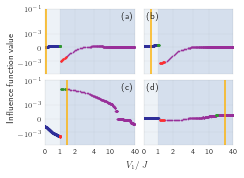

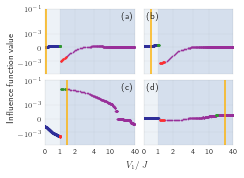

In [17]:
import numpy as np
from utility_plots import make_IF_fig2

# If you want to use a model from paper, use model_name = 'original_CNN_full_l005'
model_name = 'original_CNN_full_l005'
influence_folder = 'influence'

chosen_test_examples = np.array([1,10,22,37])

make_IF_fig2(chosen_test_examples, influence_folder, model_name, formatname = 'png', name = "IF_fig2")